In [ ]:
import os
import sys
import time
import random
import warnings
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras import backend as K

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

seed = 42
random.seed = seed

In [ ]:
def acc_comp(msk, preds_test_t):

    mean_acc = np.zeros(1)
    mean_TP = np.zeros(1)
    mean_TN = np.zeros(1)
    mean_FP = np.zeros(1)
    mean_FN = np.zeros(1)

    for j in range(msk.shape[0]):
        act = msk[j]
        pr = preds_test_t[j].reshape(IMG_WIDTH, IMG_HEIGHT)

        c = act == pr
        d = act & pr
        e = act | pr
        neg = act.sum()
        pos = (IMG_WIDTH*IMG_HEIGHT)-act.sum()

        TP = round(float(d.sum()),6)
        FP = round(float(pr.sum()-d.sum()),6)
        TN = round(float((IMG_WIDTH*IMG_HEIGHT)-e.sum()),6)
        FN = round(float(e.sum()-pr.sum()),6)
        acc = round(float(c.sum())/(IMG_WIDTH*IMG_HEIGHT),6)

        mean_TP = np.append([mean_TP],TP)
        mean_TN = np.append([mean_TN],TN)
        mean_acc = np.append([mean_acc],acc)
        mean_FP = np.append([mean_FP],FP)
        mean_FN = np.append([mean_FN],FN)

    mean_acc = mean_acc[1:]
    mean_TP = mean_TP[1:]
    mean_TN = mean_TN[1:]
    mean_FP = mean_FP[1:]
    mean_FN = mean_FN[1:]
    std = round(np.std(mean_acc),6)

    return (mean_acc,std,mean_TP,mean_TN,mean_FP,mean_FN)

class TimingCallback(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
cb = TimingCallback()

In [ ]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
import patoolib
patoolib.extract_archive("dataset.zip")

INFO patool: Extracting dataset.zip ...
INFO:patool:Extracting dataset.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_uu5kek1c -- dataset.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_uu5kek1c -- dataset.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... dataset.zip extracted to `dataset'.
INFO:patool:... dataset.zip extracted to `dataset'.


'dataset'

In [ ]:
TRAIN_PATH = ['dataset/train/images/']
MASK_PATH = ['dataset/train/masks/']
train_ids = next(os.walk(TRAIN_PATH[0]))[2]
mask_ids = next(os.walk(MASK_PATH[0]))[2]
train_ids.sort()
mask_ids.sort()
TRAIN_PATH = TRAIN_PATH*len(train_ids)
MASK_PATH = MASK_PATH*len(train_ids)

In [ ]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1))
sys.stdout.flush()
g = list(range(0,len(train_ids)))
np.random.shuffle(g)
strs_original = ["" for x in range(len(train_ids))]
strs_mask = ["" for x in range(len(train_ids))]
pathmsk = MASK_PATH[0] + mask_ids[0]
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    strs_mask[n] = MASK_PATH[n] + mask_ids[n]
    strs_original[n] = TRAIN_PATH[n] + train_ids[n]

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = strs_original[g[n]]
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

    path = strs_mask[g[n]]
    img = imread(path)
    if img.ndim == 3:
        img = img[:,:,1]
    img = np.expand_dims(resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
    if (np.unique(img).size) > 2:
        img = img > 30
    else:
        img = img > 0
    Y_train[n] = img

<ipython-input-7-9a62ae21b513>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/1464 [00:00<?, ?it/s]

<ipython-input-7-9a62ae21b513>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/1464 [00:00<?, ?it/s]

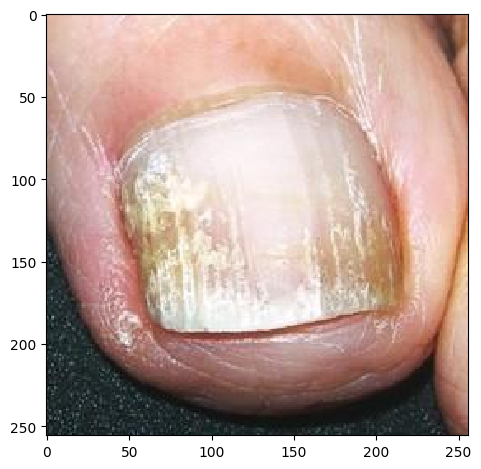

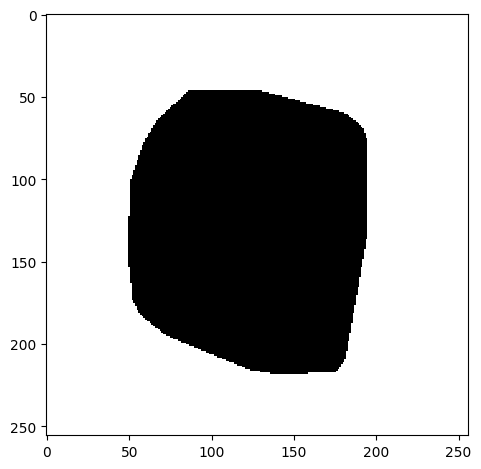

In [ ]:
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [ ]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x/255) (inputs)

# Encoder
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

# Decoder
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
checkpointer = ModelCheckpoint('model_unet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.20, batch_size=16, epochs=100, shuffle=True,
                    callbacks=[checkpointer, cb])

Epoch 1/100
 6/74 [=>............................] - ETA: 11s - loss: 0.7039 - acc: 0.5889

74/74 [==============================] - ETA: 0s - loss: 0.6246 - acc: 0.6471
Epoch 1: val_loss improved from inf to 0.52831, saving model to model_unet.h5
74/74 [==============================] - 39s 265ms/step - loss: 0.6246 - acc: 0.6471 - val_loss: 0.5283 - val_acc: 0.6568
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


73/74 [============================>.] - ETA: 0s - loss: 0.4816 - acc: 0.7196
Epoch 2: val_loss improved from 0.52831 to 0.49062, saving model to model_unet.h5
74/74 [==============================] - 13s 179ms/step - loss: 0.4814 - acc: 0.7200 - val_loss: 0.4906 - val_acc: 0.7101
Epoch 3/100
73/74 [============================>.] - ETA: 0s - loss: 0.4552 - acc: 0.8126
Epoch 3: val_loss improved from 0.49062 to 0.45785, saving model to model_unet.h5
74/74 [==============================] - 13s 181ms/step - loss: 0.4554 - acc: 0.8125 - val_loss: 0.4578 - val_acc: 0.8059
Epoch 4/100
73/74 [============================>.] - ETA: 0s - loss: 0.4439 - acc: 0.8141
Epoch 4: val_loss did not improve from 0.45785
74/74 [==============================] - 13s 180ms/step - loss: 0.4438 - acc: 0.8142 - val_loss: 0.4608 - val_acc: 0.7673
Epoch 5/100
73/74 [============================>.] - ETA: 0s - loss: 0.4290 - acc: 0.8201
Epoch 5: val_loss did not improve from 0.45785
74/74 [=====================

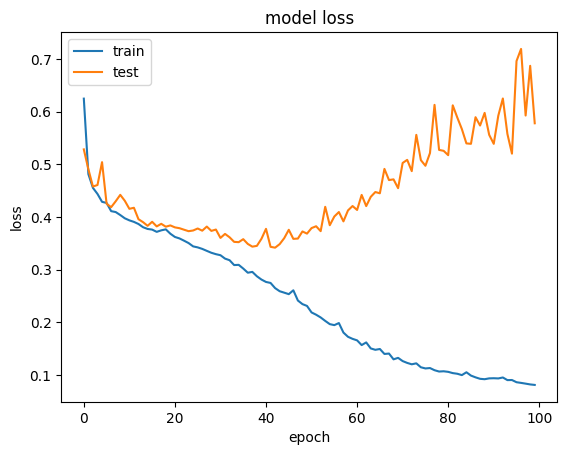

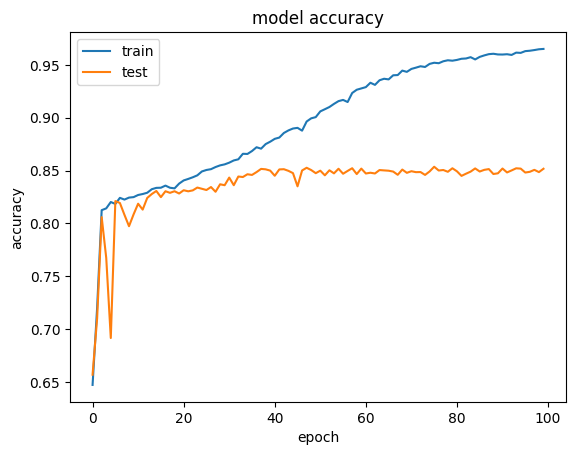

UNET ARCHITECTURE
-------------------------------------------------------------
Total num of training images: 1464
Max num of epochs: 50
Optimizer: ADAM
Batch size: 64
Loss function: Binary Cross-Entropy
Validation data percentage: 10
Early stoppping: Yes


In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print("UNET ARCHITECTURE")
print ("-------------------------------------------------------------")
print("Total num of training images: %d" % len(train_ids))
print("Max num of epochs: %d" % 50)
print("Optimizer: %s" % 'ADAM')
print("Batch size: %d" % 64)
print("Loss function: %s" % 'Binary Cross-Entropy')
print("Validation data percentage: %d" % 10)
print("Early stoppping: %s" % 'Yes')

a = results.history["acc"]
b = results.history["loss"]
c = results.history["val_acc"]
d = results.history["val_loss"]

In [ ]:
model = load_model('model_unet.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

10/10 [==============================] - 1s 58ms/step


In [ ]:
model = load_model('model_unet.h5', custom_objects={'mean_iou': mean_iou})
ABD_PATH = 'dataset/train/images/'
MSK_PATH = 'dataset/train/masks/'

abd_ids = next(os.walk(ABD_PATH))[2]
msk_ids = next(os.walk(MSK_PATH))[2]
abd_ids.sort()
msk_ids.sort()

abd = np.zeros((len(abd_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
msk = np.zeros((len(msk_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):
    path = ABD_PATH + id_
    img = imread(path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    abd[n] = img

for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):
    path = MSK_PATH + id_
    img = imread(path)

    if img.ndim == 3:
        img = img[:,:,1]

    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True)
    if (np.unique(img).size) > 2:
        img = img > 30           # Important, Needed to make labels 0's and 1's only
    else:
        img = img > 0
    img = img.astype(np.uint8)
    msk[n] = img

preds_test = model.predict(abd[:int(abd.shape[0])], verbose=1)

preds_test_t = (preds_test > 0.5).astype(np.uint8)

answer = acc_comp(msk, preds_test_t);

<ipython-input-13-d98bffce011c>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(abd_ids), total=len(abd_ids)):


  0%|          | 0/1464 [00:00<?, ?it/s]

<ipython-input-13-d98bffce011c>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm(enumerate(msk_ids), total=len(msk_ids)):


  0%|          | 0/1464 [00:00<?, ?it/s]

46/46 [==============================] - 6s 126ms/step


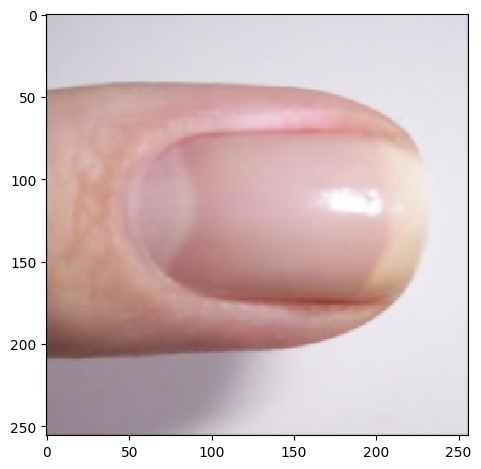

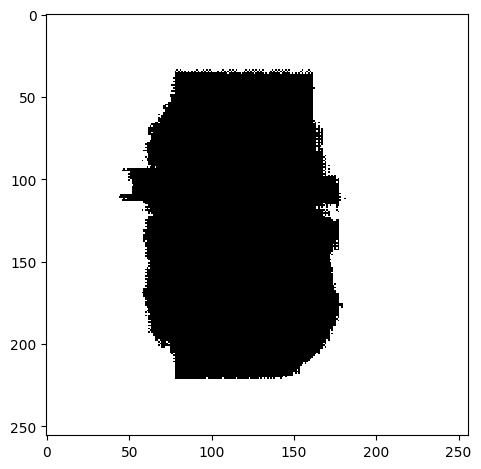

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


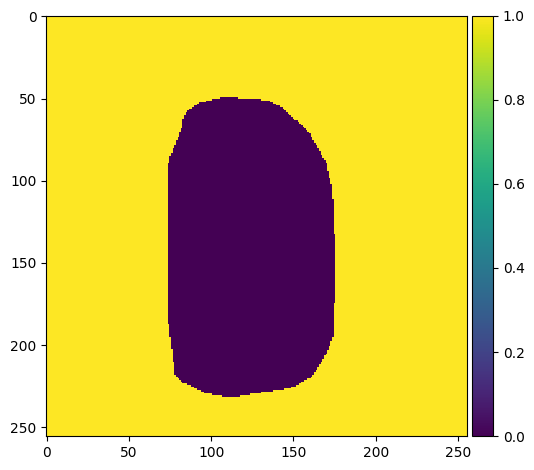

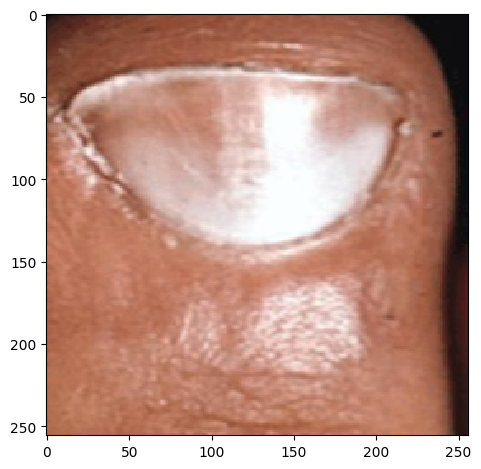

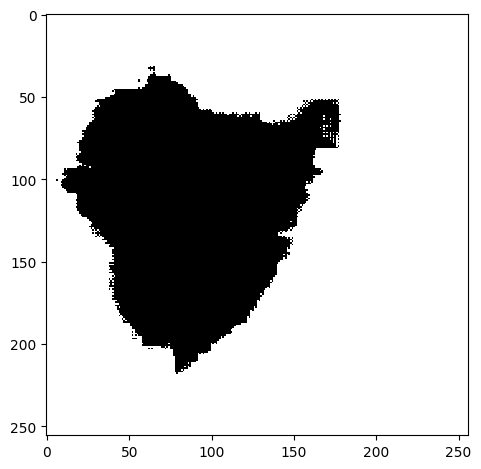

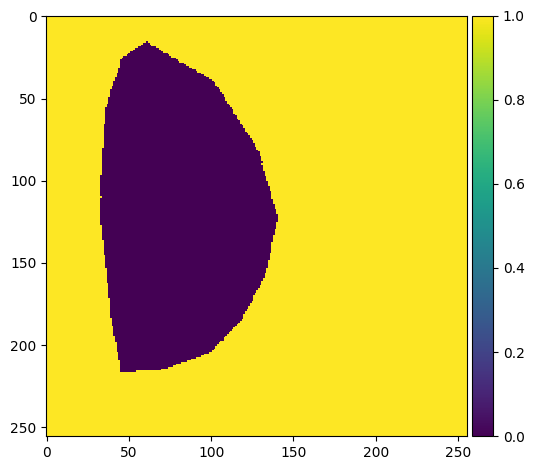

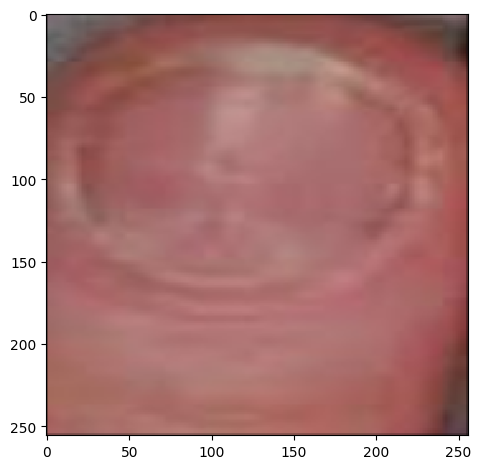

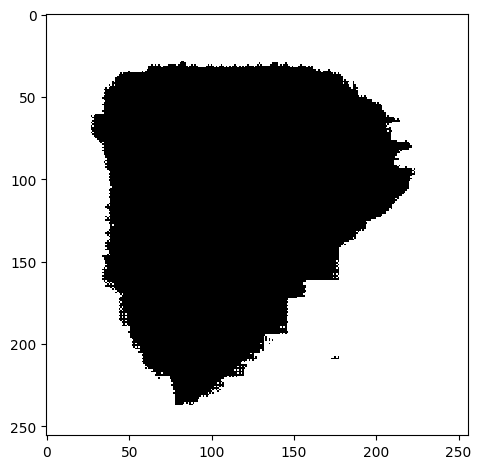

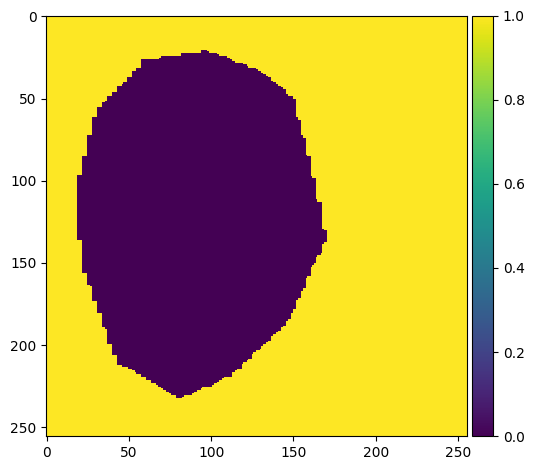

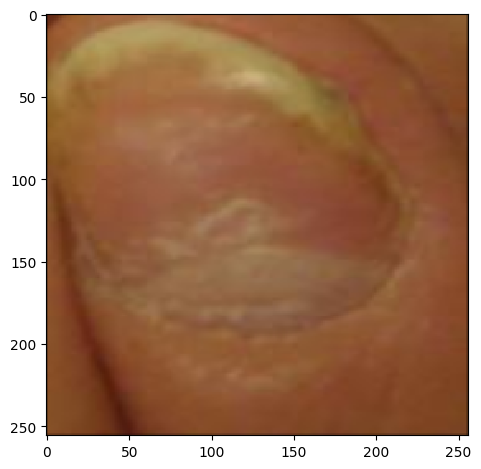

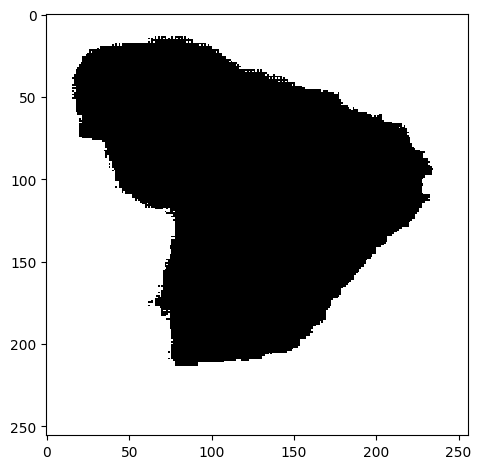

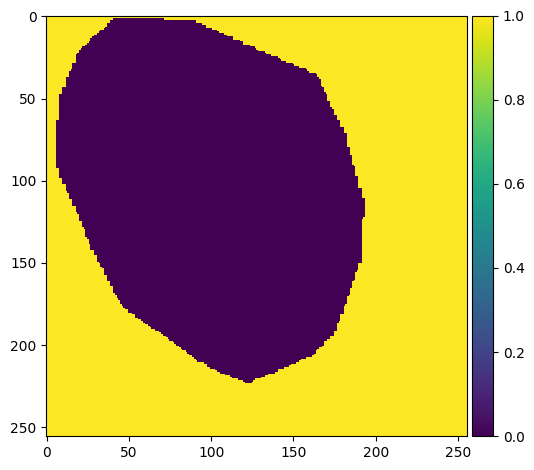

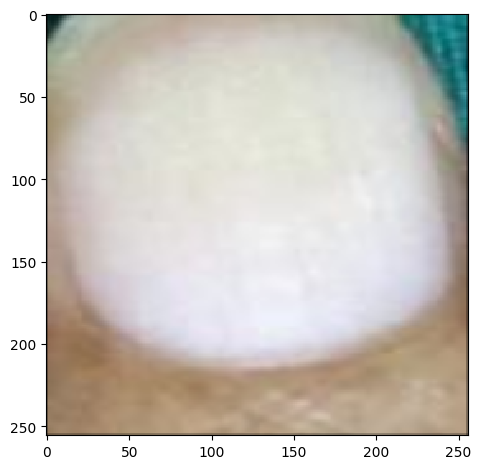

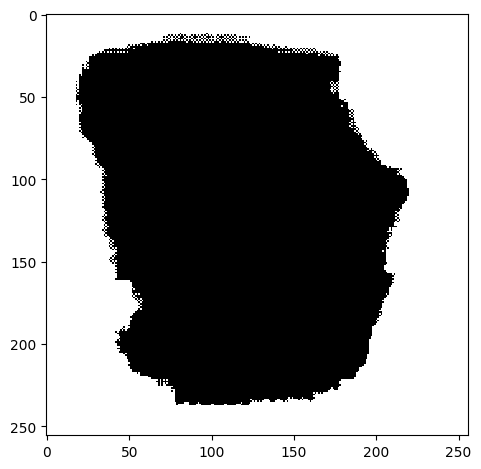

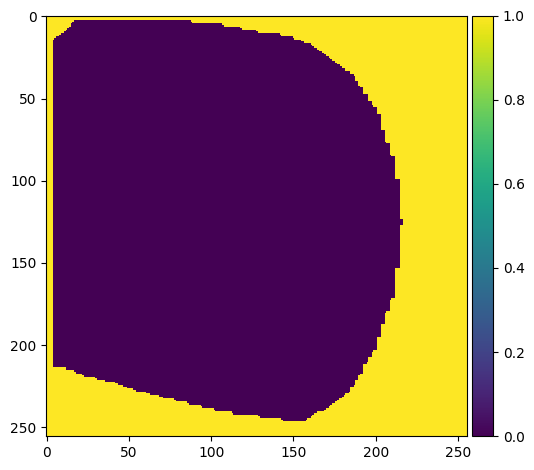

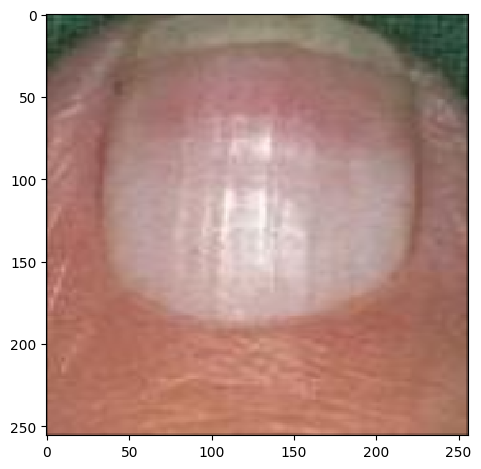

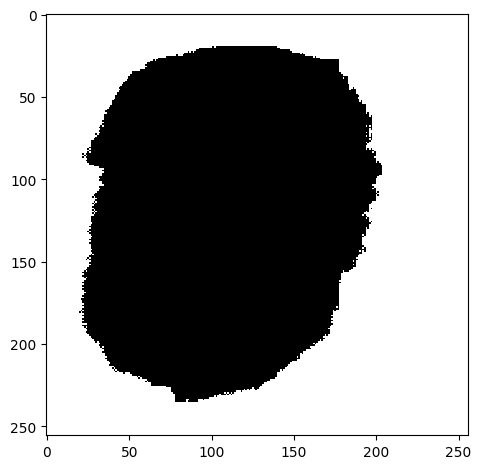

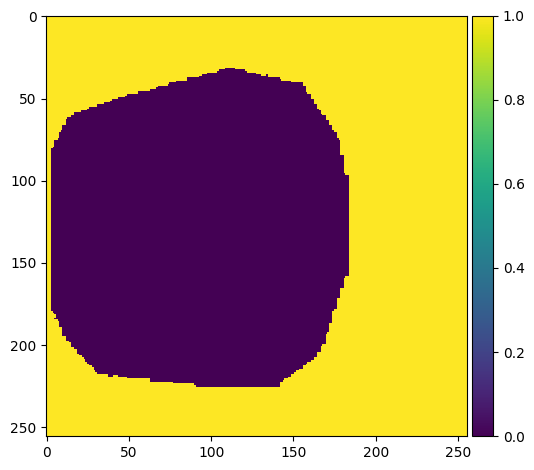

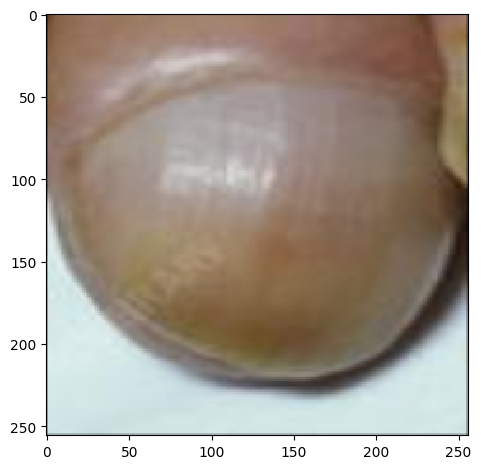

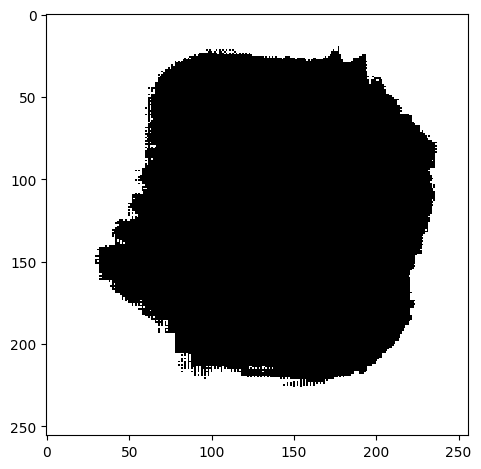

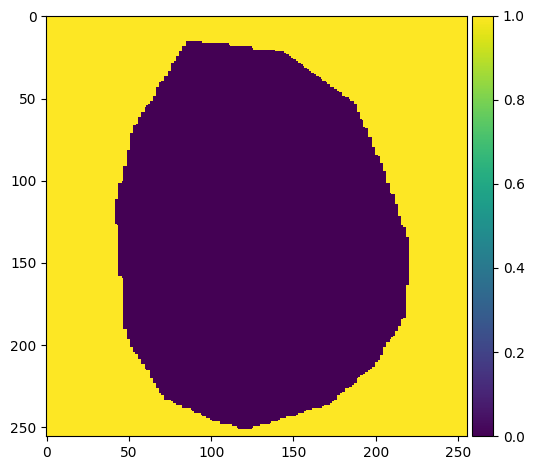

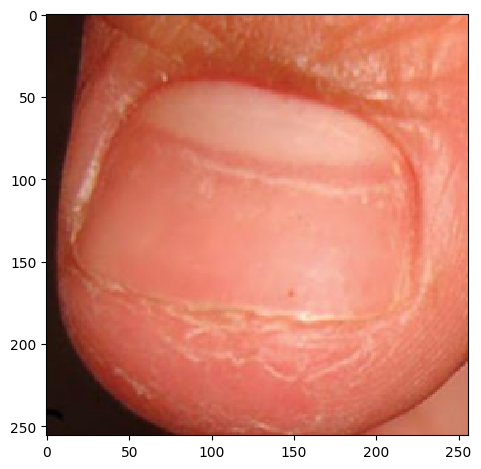

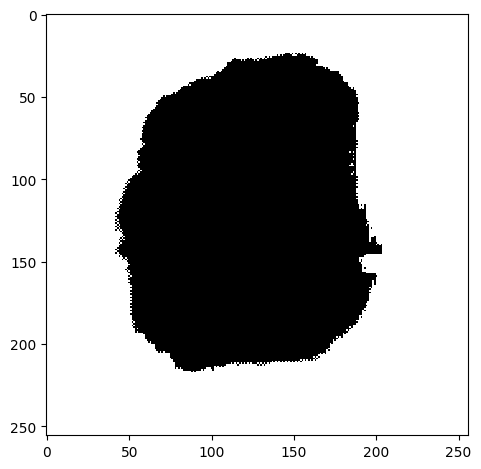

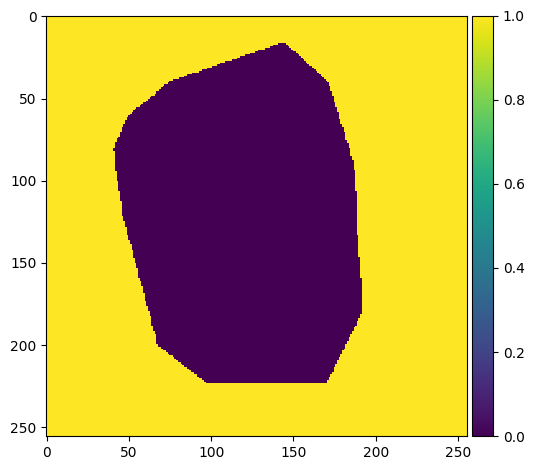

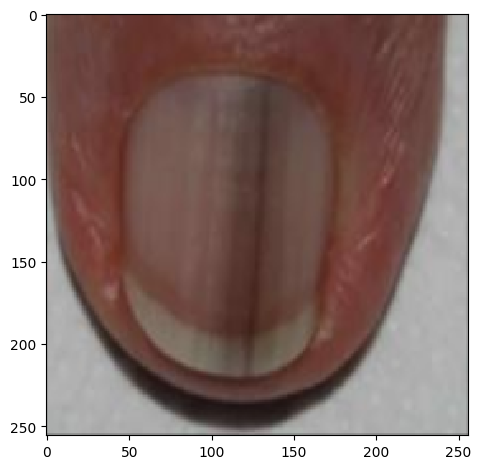

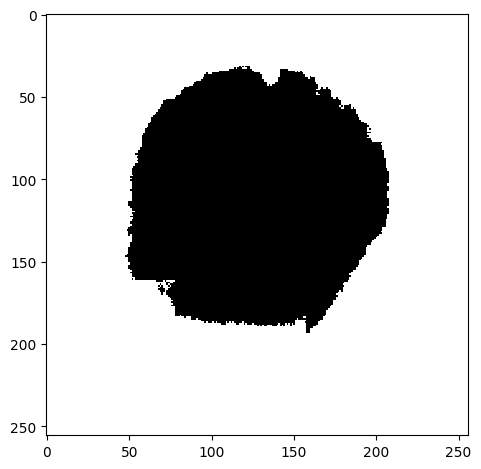

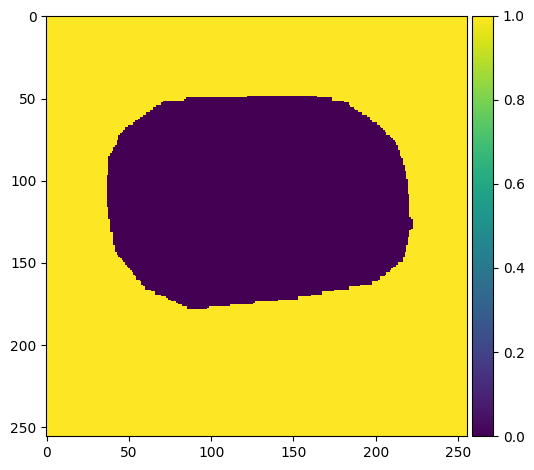

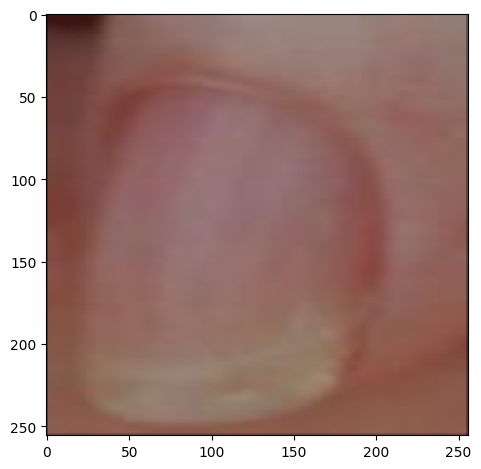

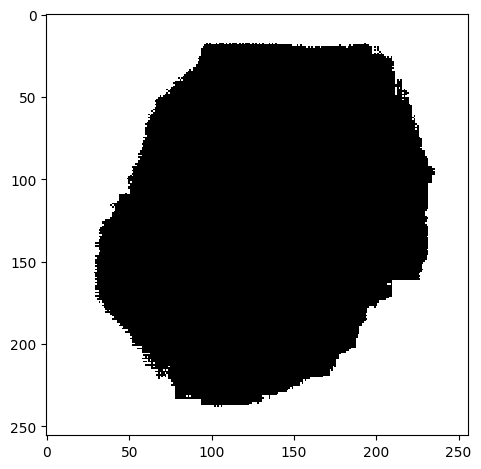

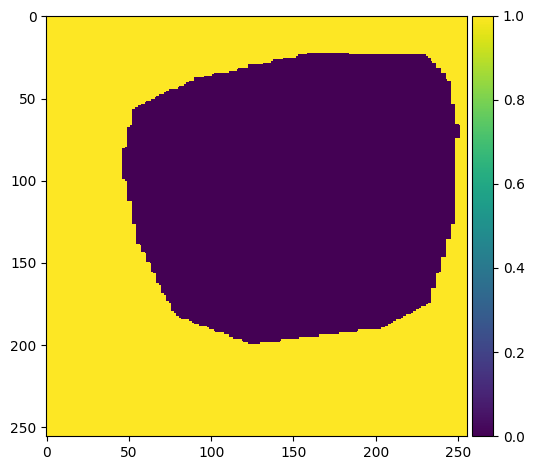

In [ ]:
for j in range(10):
    plt.show()
    imshow(abd[j])
    plt.show()
    imshow(np.squeeze(preds_test_t[j]*255))
    plt.show()
    imshow(np.squeeze(msk[j]))